In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit_machine_learning.neural_networks import EstimatorQNN,SamplerQNN
from IPython.display import clear_output
import matplotlib.pyplot as plt
import qiskit.quantum_info as qi
from qiskit.circuit import ParameterVector
from qiskit_algorithms.utils import algorithm_globals
import time as t
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import EfficientSU2,RealAmplitudes
import numpy as np
from qiskit.primitives import Estimator, Sampler
import pickle 

In [2]:
VQE_training = False
n_qubits=4
j_coupling=1
g_coupling=1.5
n_rep_VQEansatz=1


In [3]:
def getGoundState(n_qubits=n_qubits,j_coupling=j_coupling,g_coupling=g_coupling,n_rep_VQEansatz=1,nSteps=200
                 ,learning_rate=1e-2):
    h_coupling=j_coupling*g
    qr_VQE = QuantumRegister(n_qubits)
    qc_VQE = QuantumCircuit(qr_VQE)
    ansatz_VQE =  RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz)
    qc_VQE.h(qr_VQE)
    qc_VQE.compose(ansatz_VQE, inplace=True)  
    
    observable = SparsePauliOp.from_list([("X"+"I"*(n_qubits-1) , h_coupling )])
    for i in np.arange(1,n_qubits,1):
        observable=observable + SparsePauliOp.from_list([("I"*(i)+"X"+"I"*(n_qubits-1-i) , -h_coupling )])
    for i in range(n_qubits-1):
        observable=observable + (SparsePauliOp.from_list([("I"*(i)+"ZZ"+"I"*(n_qubits-2-i) ,- j_coupling)]))
        
       
    qnn_VQE=EstimatorQNN(
        estimator=Estimator(options={"shots":1e10}),
        circuit=qc_VQE,
        weight_params=ansatz_VQE.parameters,
        observables=observable
        )
    qc_VQE.draw('mpl')

    eigenValues=np.linalg.eig(observable.to_matrix())[0]
    eigenValues.sort()

    groundEnergy=eigenValues[0]
    #print("ground state energy =", groundEnergy)
    
    init_weights=np.random.rand(qnn_VQE.num_weights)*2*np.pi
    weights=init_weights
    
    loss=[]
    for i in range(nSteps):
        vev=qnn_VQE.forward([], weights)[0][0]
        input_grad, weight_grad=qnn_VQE.backward([],weights)
        grad=weight_grad[0,0,:]
        weights=weights-learning_rate*grad
        loss.append(vev)

#        if i%1==0:
            
#             clear_output(wait=True)
    
#             callback_graph(loss)
#             plt.plot(range(len(loss)),groundEnergy*np.ones(len(loss)),label='truth')
#             plt.legend()
#             #plt.yscale('log')
#             plt.show()

    return weights,vev,groundEnergy

In [4]:
if VQE_training:
    nSteps=500
    step=0.002
    lowGs=np.arange(0,1,step)
    highGs=np.arange(1+step,2.0+step,step)
    
    #################################################
    #Obtaining parameters for ground state with |g|<1 
    #################################################
    w_low=[]
    Egs_estimate_low=[]
    Egs_low=[]
    for g in lowGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e-1)
            diff=abs(Egs_estimate-Egs)/abs(Egs)

            if diff< 0.02:
                break
                
        print("g = ",g," diff=",diff)
                
        w_low.append(weights)
        Egs_estimate_low.append(Egs_estimate)
        Egs_low.append(Egs)

    print("lowG finished")
    dict_low={"weights": w_low,"E_gs_estimate": Egs_estimate_low,
              "E_gs":Egs_low,"g":lowGs}
    with open('lowG_dict.pkl', 'wb') as f:
        pickle.dump(dict_low, f)

    #################################################
    #Obtaining parameters for ground state with |g|>1
    #################################################
    
    w_high=[]
    Egs_estimate_high=[]
    Egs_high=[]
    for g in highGs:
        for i in range(5):
            weights,Egs_estimate,Egs=getGoundState(g_coupling=g,nSteps=nSteps,learning_rate=1e-1)
            diff=abs(Egs_estimate-Egs)/abs(Egs)
            if diff< 0.02:
                break
        print("g = ",g," diff=",diff)
        w_high.append(weights)
        Egs_estimate_high.append(Egs_estimate)
        Egs_high.append(Egs)

    dict_high={"weights": w_high,"E_gs_estimate":Egs_estimate_high,
               "E_gs": Egs_high ,"g":highGs}
    with open('highG_dict.pkl', 'wb') as f:
        pickle.dump(dict_high, f)
        
    ###############################################################    
    #Creating the dataset with labals. 1 for |g|>1 and -1 for |g|<1 
    ###############################################################   
    dataset={'weights':dict_low['weights']+dict_high['weights'], 
         'label': np.concatenate([-1*np.ones(len(dict_low['weights'])),np.ones(len(dict_high['weights']))])
        ,'g':np.concatenate([dict_low['g'],dict_high['g']])
        }
    
    with open('dataset.pkl', 'wb') as f:
        pickle.dump(dataset, f)
    

In [5]:
#loading the dataset
with open('dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'dataset.pkl'

In [6]:
g_train=[]
X_train=[]
y_train=[]
g_test=[]
X_test=[]
y_test=[]
for i in range(len(dataset['label'])):
    rand=np.random.rand(1)
    
    if i % 4 == 0:
  
        X_test.append(dataset['weights'][i])
        y_test.append(dataset['label'][i])
        g_test.append(dataset['g'][i])
    
    else:
        X_train.append(dataset['weights'][i])
        y_train.append(dataset['label'][i])
        g_train.append(dataset['g'][i])
        
        
        
        
#     if i > int(len(dataset['label'])/2):
#         break
    
X_train=np.array(X_train)
y_train=np.array(y_train)
g_train=np.array(g_train)

X_test=np.array(X_test)
y_test=np.array(y_test)
g_test=np.array(g_test)

print("N training events = ",X_train.shape[0])
print("N test events = ",X_test.shape[0])

y_train[y_train==-1]=0
y_test[y_test==-1]=0

NameError: name 'dataset' is not defined

In [205]:

qr = QuantumRegister(n_qubits,n_qubits)
qc = QuantumCircuit(n_qubits,n_qubits)
qc.compose(RealAmplitudes(num_qubits=n_qubits,reps=n_rep_VQEansatz), inplace=True) 
#qc.measure(qc.qubits,qc.clbits)
qc.barrier()

/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


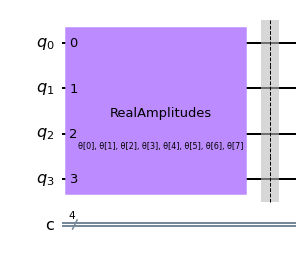

In [206]:
qc.draw('mpl')

In [207]:
estimator=Estimator()

ob_list=[]

#Symmetric ones:
ob_list.append(SparsePauliOp.from_list([("X" * n_qubits, 1)]))
ob_list.append(SparsePauliOp.from_list([("Y" * n_qubits, 1)]))
ob_list.append(SparsePauliOp.from_list([("Z" * n_qubits, 1)]))

ob_list.append(SparsePauliOp.from_list([("XXII", 1)]))
ob_list.append(SparsePauliOp.from_list([("YYII", 1)]))
ob_list.append(SparsePauliOp.from_list([("ZZII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IXXI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IYYI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IZZI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIXX", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIYY", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIZZ", 1)]))


ob_list.append(SparsePauliOp.from_list([("XIII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IXII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIXI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIIX", 1)]))

ob_list.append(SparsePauliOp.from_list([("YIII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IYII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIYI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIIY", 1)]))

ob_list.append(SparsePauliOp.from_list([("ZIII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IZII", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIZI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IIIZ", 1)]))


ob_list.append(SparsePauliOp.from_list([("XXXI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IXXX", 1)]))
ob_list.append(SparsePauliOp.from_list([("YYYI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IYYY", 1)]))
ob_list.append(SparsePauliOp.from_list([("ZZZI", 1)]))
ob_list.append(SparsePauliOp.from_list([("IZZZ", 1)]))


In [208]:
inputs_train = []
for i in range(len(y_train)):
    results = estimator.run(circuits=[qc]*len(ob_list),
                        observables=ob_list,
                        parameter_values=[X_train[i]]*len(ob_list)).result().values
    
    inputs_train .append(results)
    
inputs_train =np.array(inputs_train)

In [209]:
inputs_test = []
for i in range(len(y_test)):
    results = estimator.run(circuits=[qc]*len(ob_list),
                        observables=ob_list,
                        parameter_values=[X_test[i]]*len(ob_list)).result().values
    
    inputs_test .append(results)
    
inputs_test =np.array(inputs_test)

In [210]:

# np.random.seed(1)
# np.random.shuffle(inputs_train)
# np.random.seed(1)
# np.random.shuffle(y_train)
# np.random.seed(1)
# np.random.shuffle(g_train)


# np.random.seed(1)
# np.random.shuffle(inputs_test)
# np.random.seed(1)
# np.random.shuffle(y_test)
# np.random.seed(1)
# np.random.shuffle(g_test)

In [211]:
from sklearn.neural_network import MLPClassifier

In [212]:
n_neurons=inputs_train.shape[1]
clf = MLPClassifier(solver='lbfgs', alpha=1e-4,
                   hidden_layer_sizes=(n_neurons,n_neurons,n_neurons,n_neurons
                                      ), 
                    
                random_state=1, max_iter=100000)
#,early_stopping=True,validation_fraction=0.5,n_iter_no_change=100)


In [213]:
clf.fit(inputs_train, y_train)

MLPClassifier(hidden_layer_sizes=(30, 30, 30, 30), max_iter=100000,
              random_state=1, solver='lbfgs')

In [214]:
train_pred = clf.predict(inputs_train)
diff = train_pred-y_train
acc_train=diff[diff==0].shape[0]/diff.shape[0]
print(acc_train)

1.0


In [215]:
test_pred= clf.predict(inputs_test)
diff_test = test_pred-y_test
acc_test=diff_test[diff_test==0].shape[0]/diff_test.shape[0]
print(acc_test)

0.88


In [216]:
p=clf.predict_proba(inputs_test)[:,1]
p_train=clf.predict_proba(inputs_train)[:,1]

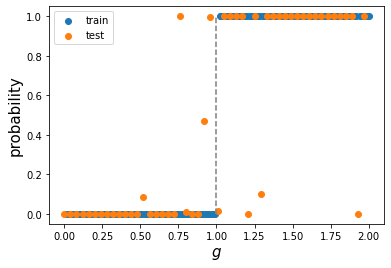

In [217]:
plt.scatter(g_train,p_train,label='train')

plt.scatter(g_test,p,label='test')
plt.vlines(x=1,ymin=0,ymax=1, colors='gray', linestyle='dashed')

plt.xlabel('$g$',fontsize='15')
plt.ylabel('probability',fontsize='15')
plt.legend()

In [218]:
inputs_train.shape

(150, 30)

In [10]:
import tensorflow as tf

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu'),
#     tf.keras.layers.Dense(inputs_train.shape[1], activation='relu'),
#     tf.keras.layers.Dense(inputs_train.shape[1], activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid'),  
])


In [8]:
# loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)


NameError: name 'tf' is not defined

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['BinaryCrossentropy','accuracy'])


NameError: name 'model' is not defined

In [232]:
history = model.fit(inputs_train, y_train, validation_split = 0.1 ,epochs=500)


Epoch 1/500
5/5 [==============================] - 0s 16ms/step - loss: 0.6824 - binary_crossentropy: 0.6824 - accuracy: 0.5556 - val_loss: 0.7462 - val_binary_crossentropy: 0.7462 - val_accuracy: 0.0000e+00
Epoch 2/500
5/5 [==============================] - 0s 3ms/step - loss: 0.6733 - binary_crossentropy: 0.6733 - accuracy: 0.5556 - val_loss: 0.7695 - val_binary_crossentropy: 0.7695 - val_accuracy: 0.0000e+00
Epoch 3/500
5/5 [==============================] - 0s 3ms/step - loss: 0.6654 - binary_crossentropy: 0.6654 - accuracy: 0.5556 - val_loss: 0.7880 - val_binary_crossentropy: 0.7880 - val_accuracy: 0.0000e+00
Epoch 4/500
5/5 [==============================] - 0s 3ms/step - loss: 0.6567 - binary_crossentropy: 0.6567 - accuracy: 0.5556 - val_loss: 0.7909 - val_binary_crossentropy: 0.7909 - val_accuracy: 0.0000e+00
Epoch 5/500
5/5 [==============================] - 0s 3ms/step - loss: 0.6481 - binary_crossentropy: 0.6481 - accuracy: 0.5778 - val_loss: 0.7967 - val_binary_crossentropy

5/5 [==============================] - 0s 3ms/step - loss: 0.0944 - binary_crossentropy: 0.0944 - accuracy: 0.9778 - val_loss: 0.6641 - val_binary_crossentropy: 0.6641 - val_accuracy: 0.7333
Epoch 42/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0845 - binary_crossentropy: 0.0845 - accuracy: 0.9926 - val_loss: 0.6717 - val_binary_crossentropy: 0.6717 - val_accuracy: 0.7333
Epoch 43/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0788 - binary_crossentropy: 0.0788 - accuracy: 0.9778 - val_loss: 0.5398 - val_binary_crossentropy: 0.5398 - val_accuracy: 0.7333
Epoch 44/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0781 - binary_crossentropy: 0.0781 - accuracy: 0.9778 - val_loss: 0.5610 - val_binary_crossentropy: 0.5610 - val_accuracy: 0.7333
Epoch 45/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0709 - binary_crossentropy: 0.0709 - accuracy: 0.9926 - val_loss: 0.7409 - val_binary_crossentropy: 0.7409 - val_accuracy: 

5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - binary_crossentropy: 0.0023 - accuracy: 1.0000 - val_loss: 0.5928 - val_binary_crossentropy: 0.5928 - val_accuracy: 0.7333
Epoch 122/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0023 - binary_crossentropy: 0.0023 - accuracy: 1.0000 - val_loss: 0.5868 - val_binary_crossentropy: 0.5868 - val_accuracy: 0.7333
Epoch 123/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - binary_crossentropy: 0.0022 - accuracy: 1.0000 - val_loss: 0.6160 - val_binary_crossentropy: 0.6160 - val_accuracy: 0.7333
Epoch 124/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - binary_crossentropy: 0.0022 - accuracy: 1.0000 - val_loss: 0.6363 - val_binary_crossentropy: 0.6363 - val_accuracy: 0.7333
Epoch 125/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0022 - binary_crossentropy: 0.0022 - accuracy: 1.0000 - val_loss: 0.6468 - val_binary_crossentropy: 0.6468 - val_accura

5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.6185 - val_binary_crossentropy: 0.6185 - val_accuracy: 0.7333
Epoch 162/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.6094 - val_binary_crossentropy: 0.6094 - val_accuracy: 0.7333
Epoch 163/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.6035 - val_binary_crossentropy: 0.6035 - val_accuracy: 0.7333
Epoch 164/500
5/5 [==============================] - 0s 3ms/step - loss: 0.0010 - binary_crossentropy: 0.0010 - accuracy: 1.0000 - val_loss: 0.6101 - val_binary_crossentropy: 0.6101 - val_accuracy: 0.7333
Epoch 165/500
5/5 [==============================] - 0s 3ms/step - loss: 9.8144e-04 - binary_crossentropy: 9.8144e-04 - accuracy: 1.0000 - val_loss: 0.6079 - val_binary_crossentropy: 0.6079 - va

Epoch 200/500
5/5 [==============================] - 0s 3ms/step - loss: 5.9892e-04 - binary_crossentropy: 5.9892e-04 - accuracy: 1.0000 - val_loss: 0.6267 - val_binary_crossentropy: 0.6267 - val_accuracy: 0.7333
Epoch 201/500
5/5 [==============================] - 0s 3ms/step - loss: 5.8701e-04 - binary_crossentropy: 5.8701e-04 - accuracy: 1.0000 - val_loss: 0.6296 - val_binary_crossentropy: 0.6296 - val_accuracy: 0.7333
Epoch 202/500
5/5 [==============================] - 0s 3ms/step - loss: 5.7701e-04 - binary_crossentropy: 5.7701e-04 - accuracy: 1.0000 - val_loss: 0.6340 - val_binary_crossentropy: 0.6340 - val_accuracy: 0.7333
Epoch 203/500
5/5 [==============================] - 0s 3ms/step - loss: 5.5893e-04 - binary_crossentropy: 5.5893e-04 - accuracy: 1.0000 - val_loss: 0.6467 - val_binary_crossentropy: 0.6467 - val_accuracy: 0.7333
Epoch 204/500
5/5 [==============================] - 0s 3ms/step - loss: 5.5388e-04 - binary_crossentropy: 5.5388e-04 - accuracy: 1.0000 - val_loss:

5/5 [==============================] - 0s 3ms/step - loss: 2.5549e-04 - binary_crossentropy: 2.5549e-04 - accuracy: 1.0000 - val_loss: 0.6546 - val_binary_crossentropy: 0.6546 - val_accuracy: 0.7333
Epoch 277/500
5/5 [==============================] - 0s 3ms/step - loss: 2.5373e-04 - binary_crossentropy: 2.5373e-04 - accuracy: 1.0000 - val_loss: 0.6600 - val_binary_crossentropy: 0.6600 - val_accuracy: 0.7333
Epoch 278/500
5/5 [==============================] - 0s 3ms/step - loss: 2.5250e-04 - binary_crossentropy: 2.5250e-04 - accuracy: 1.0000 - val_loss: 0.6642 - val_binary_crossentropy: 0.6642 - val_accuracy: 0.7333
Epoch 279/500
5/5 [==============================] - 0s 3ms/step - loss: 2.5115e-04 - binary_crossentropy: 2.5115e-04 - accuracy: 1.0000 - val_loss: 0.6649 - val_binary_crossentropy: 0.6649 - val_accuracy: 0.7333
Epoch 280/500
5/5 [==============================] - 0s 3ms/step - loss: 2.4993e-04 - binary_crossentropy: 2.4993e-04 - accuracy: 1.0000 - val_loss: 0.6638 - val_

5/5 [==============================] - 0s 3ms/step - loss: 1.3516e-04 - binary_crossentropy: 1.3516e-04 - accuracy: 1.0000 - val_loss: 0.6829 - val_binary_crossentropy: 0.6829 - val_accuracy: 0.7333
Epoch 353/500
5/5 [==============================] - 0s 3ms/step - loss: 1.3460e-04 - binary_crossentropy: 1.3460e-04 - accuracy: 1.0000 - val_loss: 0.6832 - val_binary_crossentropy: 0.6832 - val_accuracy: 0.7333
Epoch 354/500
5/5 [==============================] - 0s 3ms/step - loss: 1.3348e-04 - binary_crossentropy: 1.3348e-04 - accuracy: 1.0000 - val_loss: 0.6839 - val_binary_crossentropy: 0.6839 - val_accuracy: 0.7333
Epoch 355/500
5/5 [==============================] - 0s 3ms/step - loss: 1.3342e-04 - binary_crossentropy: 1.3342e-04 - accuracy: 1.0000 - val_loss: 0.6807 - val_binary_crossentropy: 0.6807 - val_accuracy: 0.7333
Epoch 356/500
5/5 [==============================] - 0s 3ms/step - loss: 1.3184e-04 - binary_crossentropy: 1.3184e-04 - accuracy: 1.0000 - val_loss: 0.6817 - val_

5/5 [==============================] - 0s 3ms/step - loss: 8.2030e-05 - binary_crossentropy: 8.2030e-05 - accuracy: 1.0000 - val_loss: 0.6892 - val_binary_crossentropy: 0.6892 - val_accuracy: 0.7333
Epoch 429/500
5/5 [==============================] - 0s 3ms/step - loss: 8.1691e-05 - binary_crossentropy: 8.1691e-05 - accuracy: 1.0000 - val_loss: 0.6917 - val_binary_crossentropy: 0.6917 - val_accuracy: 0.7333
Epoch 430/500
5/5 [==============================] - 0s 3ms/step - loss: 8.1036e-05 - binary_crossentropy: 8.1036e-05 - accuracy: 1.0000 - val_loss: 0.6937 - val_binary_crossentropy: 0.6937 - val_accuracy: 0.7333
Epoch 431/500
5/5 [==============================] - 0s 3ms/step - loss: 8.0375e-05 - binary_crossentropy: 8.0375e-05 - accuracy: 1.0000 - val_loss: 0.6966 - val_binary_crossentropy: 0.6966 - val_accuracy: 0.7333
Epoch 432/500
5/5 [==============================] - 0s 3ms/step - loss: 8.0050e-05 - binary_crossentropy: 8.0050e-05 - accuracy: 1.0000 - val_loss: 0.7043 - val_

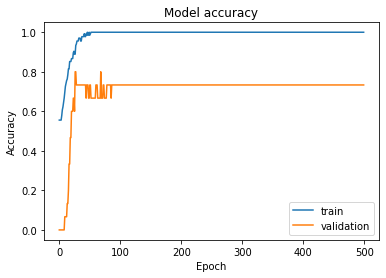

In [233]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'])
plt.show()

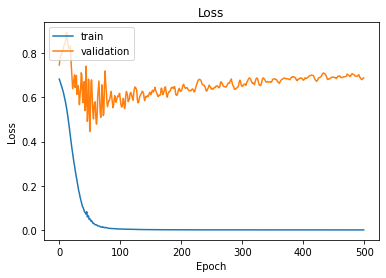

In [234]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [235]:
test_eval=model.evaluate(inputs_test,  y_test, verbose=1)

2/2 [==============================] - 0s 2ms/step - loss: 0.6012 - binary_crossentropy: 0.6012 - accuracy: 0.8800


In [236]:
predict_test=model.predict(inputs_test).flatten()

2/2 [==============================] - 0s 1ms/step


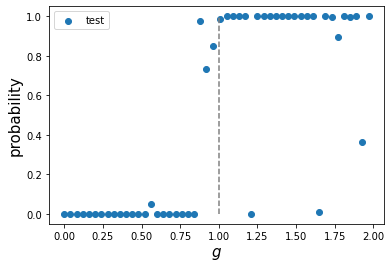

In [237]:


plt.scatter(g_test,predict_test,label='test')
plt.vlines(x=1,ymin=0,ymax=1, colors='gray', linestyle='dashed')

plt.xlabel('$g$',fontsize='15')
plt.ylabel('probability',fontsize='15')
plt.legend()